# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
#env = UnityEnvironment(file_name='envs/Reacher_Windows_x86_64/Reacher.exe')
env = UnityEnvironment(file_name='envs/Reacher_multi_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {:.2f}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33.00
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
for _ in range(500):
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.10549999764189125


### 4. Training a DDPG Agent

## 4.1 Import libraries

In [6]:
import numpy as np

import random
import copy
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

## 4.2 Define Helpful Functions

In [7]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

def graph_scores(scores): 
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores) + 1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

## 4.3 Define Actor and Critic Networks Models

In [8]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        
        x = self.fc1(state)
        x = F.relu(self.bn(x))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        x = self.fc1(state)
        x = F.relu(self.bn(x))
        x = torch.cat((x, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## 4.4 Define Agent

In [9]:
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0.0000     # L2 weight decay
BATCH_SIZE = 1024         # minibatch size
BUFFER_SIZE = int(1e6)  # replay buffer size

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, fc1=400, fc2=300, 
                 lra=LR_ACTOR, lrc=LR_CRITIC, initial_hard_update = False):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
            fc1 (int) : number of units in the 1st hidden layer
            fc2 (int) : number of units int he 2nd hidden layer
            initial_hard_update (boolean) : set to True if the local and target networks should be initalised to the same weights
            lra (float) : the learning rate for the Actor
            lrc (float) : the learning rate for the Critic
            
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)      
        
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed, fc1_units = fc1, fc2_units=fc2).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed, fc1_units = fc1, fc2_units=fc2).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=lra)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed, fc1_units = fc1, fc2_units=fc2).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed, fc1_units = fc1, fc2_units=fc2).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=lrc, weight_decay=WEIGHT_DECAY)
        
        # Initialse weights to be the same (hard-update) - helps convergence
        self.hard_update(self.critic_local, self.critic_target)
        self.hard_update(self.actor_local, self.actor_target)                     


        # Noise process
        self.noise = OUNoise(action_size, random_seed)
        
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        
        # Print Agent config
        print ("Agent Configuration")
        print("State Size: ", self.state_size)
        print("Action Size:", self.action_size)
        print("Network Size:", fc1, fc2)
        print("Initial Hard Update", initial_hard_update)
        print("Actor LR:", lra)
        print("Critic LR:", lrc)
        print ("**************")

    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def start_learn(self):
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)
        
    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks (soft update)----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def hard_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(local_param.data)
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([np.random.randn() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## 4.4 Define DDPG Learning Algorithm

In [10]:
def ddpg(env, agent, num_episodes=2000, max_t=1000, learn_every=20, learn_steps=10, goal_score=30, goal_period=100):
    """ implementaion of the DDPG learning algorithm
    
    env (UnityEnvironment) : The Unity Environment to train against
    agent (Agent) : The Agent to use in the learning
    num_episodes (int) : the max number of episodes to train for
    max_t (int) : The max number of timesteps to train for in each episode
    learn_every (int) : the number of timesteps between learning epochs
    learn_steps (int) : the number of learning steps to take in each learning epoch
    goal_score (int)  : the target average game score to achieve over the goal_period
    goal_period (int) : the number of episodes to average the score over to determine if the environment is mastered
    
    """
    
    print("DDPG Configuration")
    print("Max Episodes", num_episodes)
    print("Max Steps per Episode", max_t)
    print("Learning epoch every" , learn_every)
    print("Number of Learning steps per learning epoch", learn_steps)
    print("Goal Score", goal_score)
    print("Goal Score Period", goal_period)
    print("********************")
    
    period_scores_deque = deque(maxlen=goal_period)
    all_avg_scores = []
    
    for i_episode in range(1, num_episodes+1):
        # Reset Env and Agent
        env_info = env.reset(train_mode=True)[brain_name]       # reset the environment    
        states = env_info.vector_observations                   # get the current state (for each agent)
        scores = np.zeros(num_agents)                            # initialize the score (for each agent)
        agent.reset()
        
        for t in range(max_t):
            actions = agent.act(states)
            
            env_info = env.step(actions)[brain_name]            # send all actions to the environment
            next_states = env_info.vector_observations          # get next state (for each agent)
            rewards = env_info.rewards                          # get reward (for each agent)
            
            dones = env_info.local_done                         # see if episode finished
            
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done) # send actions to the agent
            
            scores += env_info.rewards                           # update the score (for each agent)
            states = next_states                                # roll over states to next time step
            
            if t % learn_every == 0:
                for _ in range(learn_steps):
                    agent.start_learn()
            
            if np.any(dones):                                   # exit loop if episode finished
                break
    
        mean_score = np.mean(scores)
        min_score = np.min(scores)
        max_score = np.max(scores)
        period_scores_deque.append(mean_score)
        all_avg_scores.append(mean_score)
        period_average_score = np.mean(period_scores_deque)
        
        print('\rEpisode {}\tPeriod Average Score: {:.2f}\tMean: {:.2f}\tMin: {:.2f}\tMax: {:.2f}'
              .format(i_episode, period_average_score, mean_score, min_score, max_score), end="")

        if i_episode % 25 == 0:
            print('\rEpisode {}\tPeriod Average Score: {:.2f}\tMean: {:.2f}\tMin: {:.2f}\tMax: {:.2f}'
              .format(i_episode, period_average_score, mean_score, min_score, max_score))  
            
        if period_average_score >= goal_score and i_episode >= goal_period:
            print('\nProblem Solved after {} epsisodes!! Total Average score: {:.2f}'.format(i_episode, period_average_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    
    return all_avg_scores

## 4.5 Train an Agent

In [11]:
random_seed = 73

### 4.5.1 Training experiments
The following is a set of small learning experiments to determine the effect of different attributes on the ability to learn
While the overall goal is to reach an average score of 30 or more over 100 episodes, these experiments aim to test the attribute configuration in a smaller (and hopefully quicker) games where the goal is to reach an average score of 10 or more over 10 episodes with a maximum of 50 episodes.

The experiments include:
* Using an initial Hard Update to initialise the local and target networks to the same weights
* Different Hidden Layer configurations
* Different Learning Rates
* Using different Learning Patterns (learning step size and learning iterations)

Based on the experiments a configuration will be trained to reach an avearge score of 30 or more over 100 episodes.

For the purposes of these experiments and this workbook *good* means meets the enviroment objective in the fewest number of episodes. The length of time to train a single episode is not being considered here (although is an important point).

In [71]:
exp_goal_score = 10
exp_goal_period = 10
exp_num_episodes = 50

Agent Configuration
State Size:  33
Action Size: 4
Network Size: 400 300
Initial Hard Update False
Actor LR: 0.001
Critic LR: 0.001
**************
DDPG Configuration
Max Episodes 50
Max Steps per Episode 1000
Learning epoch every 20
Number of Learning steps per learning epoch 10
Goal Score 10
Goal Score Period 10
********************
Episode 25	Period Average Score: 7.17	Mean: 11.66	Min: 5.57	Max: 17.55
Episode 28	Period Average Score: 10.81	Mean: 16.63	Min: 4.96	Max: 23.72Problem Solved after 28 epsisodes!! Total Average score: 10.81


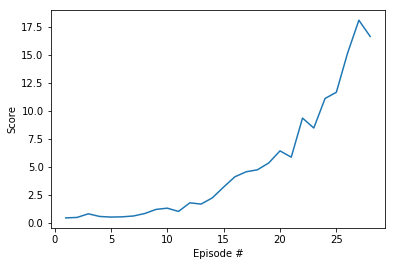

In [72]:
# Baseline configuration
agent = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed)
scores = ddpg(env, agent, goal_score = exp_goal_score, goal_period = exp_goal_period, num_episodes = exp_num_episodes)
graph_scores(scores)

Agent Configuration
State Size:  33
Action Size: 4
Network Size: 400 300
Initial Hard Update True
Actor LR: 0.001
Critic LR: 0.001
**************
DDPG Configuration
Max Episodes 50
Max Steps per Episode 1000
Learning epoch every 20
Number of Learning steps per learning epoch 10
Goal Score 10
Goal Score Period 10
********************
Episode 25	Period Average Score: 8.63	Mean: 13.34	Min: 7.94	Max: 20.93
Episode 27	Period Average Score: 10.46	Mean: 15.44	Min: 9.60	Max: 23.02Problem Solved after 27 epsisodes!! Total Average score: 10.46


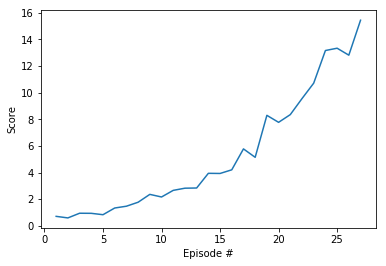

In [73]:
# Using an initial hard update of local and target networks
agent = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed, initial_hard_update=True)
scores = ddpg(env, agent, goal_score = exp_goal_score, goal_period = exp_goal_period, num_episodes = exp_num_episodes)
graph_scores(scores)

Agent Configuration
State Size:  33
Action Size: 4
Network Size: 256 128
Initial Hard Update False
Actor LR: 0.001
Critic LR: 0.001
**************
DDPG Configuration
Max Episodes 50
Max Steps per Episode 1000
Learning epoch every 20
Number of Learning steps per learning epoch 10
Goal Score 10
Goal Score Period 10
********************
Episode 25	Period Average Score: 6.80	Mean: 10.21	Min: 3.20	Max: 19.22
Episode 29	Period Average Score: 10.65	Mean: 16.67	Min: 7.21	Max: 22.52Problem Solved after 29 epsisodes!! Total Average score: 10.65


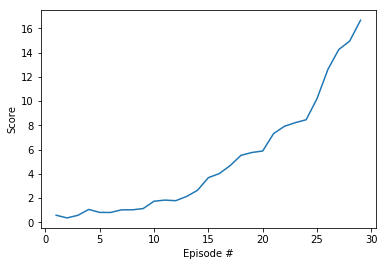

In [74]:
# Using a Smaller network
agent = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed, fc1=256, fc2=128)
scores = ddpg(env, agent, goal_score = exp_goal_score, goal_period = exp_goal_period, num_episodes = exp_num_episodes)
graph_scores(scores)

Agent Configuration
State Size:  33
Action Size: 4
Network Size: 600 400
Initial Hard Update False
Actor LR: 0.001
Critic LR: 0.001
**************
DDPG Configuration
Max Episodes 50
Max Steps per Episode 1000
Learning epoch every 20
Number of Learning steps per learning epoch 10
Goal Score 10
Goal Score Period 10
********************
Episode 25	Period Average Score: 2.80	Mean: 4.54	Min: 2.07	Max: 7.71
Episode 45	Period Average Score: 10.39	Mean: 14.12	Min: 8.62	Max: 19.88
Problem Solved after 45 epsisodes!! Total Average score: 10.39


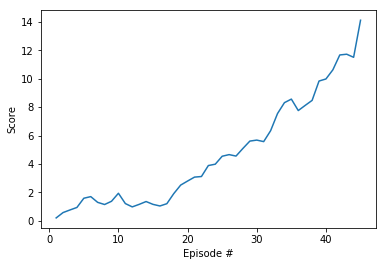

In [78]:
# Using a slighly larger network
agent = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed, fc1=600, fc2=400)
scores = ddpg(env, agent, goal_score = exp_goal_score, goal_period = exp_goal_period, num_episodes = exp_num_episodes)
graph_scores(scores)

Agent Configuration
State Size:  33
Action Size: 4
Network Size: 1028 512
Initial Hard Update False
Actor LR: 0.001
Critic LR: 0.001
**************
DDPG Configuration
Max Episodes 50
Max Steps per Episode 1000
Learning epoch every 20
Number of Learning steps per learning epoch 10
Goal Score 10
Goal Score Period 10
********************
Episode 25	Period Average Score: 4.59	Mean: 5.76	Min: 2.03	Max: 10.47
Episode 36	Period Average Score: 10.26	Mean: 12.10	Min: 4.54	Max: 26.27Problem Solved after 36 epsisodes!! Total Average score: 10.26


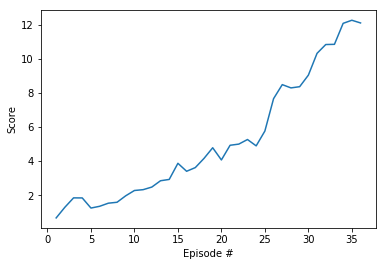

In [75]:
# Using a larger network
agent = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed, fc1=1028, fc2=512)
scores = ddpg(env, agent, goal_score = exp_goal_score, goal_period = exp_goal_period, num_episodes = exp_num_episodes)
graph_scores(scores)

Agent Configuration
State Size:  33
Action Size: 4
Network Size: 400 300
Initial Hard Update False
Actor LR: 0.001
Critic LR: 0.001
**************
DDPG Configuration
Max Episodes 50
Max Steps per Episode 1000
Learning epoch every 30
Number of Learning steps per learning epoch 10
Goal Score 10
Goal Score Period 10
********************
Episode 25	Period Average Score: 4.83	Mean: 7.67	Min: 4.65	Max: 13.06
Episode 32	Period Average Score: 10.84	Mean: 16.72	Min: 8.95	Max: 24.37
Problem Solved after 32 epsisodes!! Total Average score: 10.84


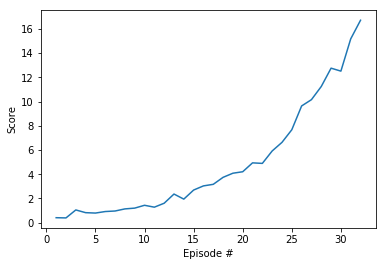

In [79]:
# Learning less frequently
agent = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed)
scores = ddpg(env, agent, goal_score = exp_goal_score, goal_period = exp_goal_period, num_episodes = exp_num_episodes, 
              learn_every = 30)
graph_scores(scores)

Agent Configuration
State Size:  33
Action Size: 4
Network Size: 400 300
Initial Hard Update False
Actor LR: 0.001
Critic LR: 0.001
**************
DDPG Configuration
Max Episodes 50
Max Steps per Episode 1000
Learning epoch every 10
Number of Learning steps per learning epoch 10
Goal Score 10
Goal Score Period 10
********************
Episode 20	Period Average Score: 11.20	Mean: 19.69	Min: 11.05	Max: 30.82
Problem Solved after 20 epsisodes!! Total Average score: 11.20


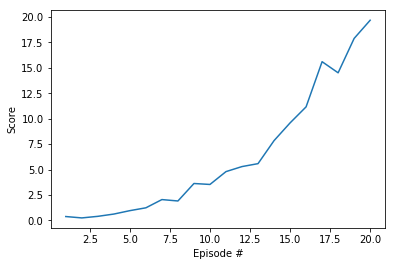

In [80]:
# Learning more frequently
agent = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed)
scores = ddpg(env, agent, goal_score = exp_goal_score, goal_period = exp_goal_period, num_episodes = exp_num_episodes, 
              learn_every = 10)
graph_scores(scores)

Agent Configuration
State Size:  33
Action Size: 4
Network Size: 400 300
Initial Hard Update False
Actor LR: 0.001
Critic LR: 0.001
**************
DDPG Configuration
Max Episodes 50
Max Steps per Episode 1000
Learning epoch every 20
Number of Learning steps per learning epoch 20
Goal Score 10
Goal Score Period 10
********************
Episode 22	Period Average Score: 10.98	Mean: 17.54	Min: 9.53	Max: 28.57
Problem Solved after 22 epsisodes!! Total Average score: 10.98


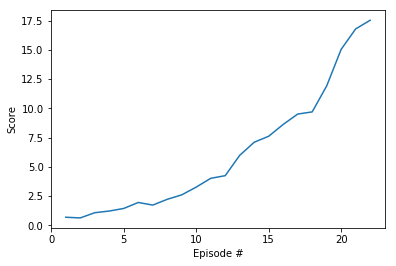

In [81]:
# Learn more per learning epoch
agent = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed)
scores = ddpg(env, agent, goal_score = exp_goal_score, goal_period = exp_goal_period, num_episodes = exp_num_episodes, 
              learn_steps = 20)
graph_scores(scores)

Agent Configuration
State Size:  33
Action Size: 4
Network Size: 400 300
Initial Hard Update False
Actor LR: 0.001
Critic LR: 0.001
**************
DDPG Configuration
Max Episodes 50
Max Steps per Episode 1000
Learning epoch every 20
Number of Learning steps per learning epoch 5
Goal Score 10
Goal Score Period 10
********************
Episode 25	Period Average Score: 3.13	Mean: 5.04	Min: 2.13	Max: 8.60
Episode 39	Period Average Score: 10.53	Mean: 13.51	Min: 5.50	Max: 20.94
Problem Solved after 39 epsisodes!! Total Average score: 10.53


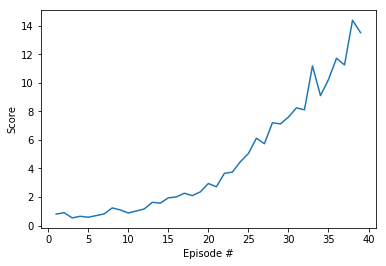

In [82]:
# Learn less per learning epoch
agent = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed)
scores = ddpg(env, agent, goal_score = exp_goal_score, goal_period = exp_goal_period, num_episodes = exp_num_episodes, 
              learn_steps = 5)
graph_scores(scores)

### 4.5.2 Training a good Agent

Agent Configuration
State Size:  33
Action Size: 4
Network Size: 400 300
Initial Hard Update True
Actor LR: 0.001
Critic LR: 0.001
**************
DDPG Configuration
Max Episodes 2000
Max Steps per Episode 1000
Learning epoch every 10
Number of Learning steps per learning epoch 20
Goal Score 30
Goal Score Period 100
********************
Episode 25	Period Average Score: 15.65	Mean: 28.98	Min: 20.30	Max: 36.92
Episode 50	Period Average Score: 25.02	Mean: 34.29	Min: 30.79	Max: 36.32
Episode 75	Period Average Score: 28.73	Mean: 37.68	Min: 35.20	Max: 39.40
Episode 100	Period Average Score: 30.90	Mean: 36.96	Min: 35.12	Max: 38.93

Problem Solved after 100 epsisodes!! Total Average score: 30.90


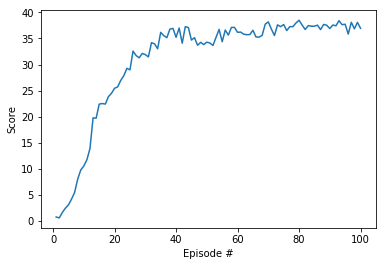

In [12]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed, initial_hard_update=True)
scores = ddpg(env, agent, learn_every = 10, learn_steps = 20)
graph_scores(scores)

# 5 Watch the trained Agent

In [13]:
# Load the saved weights
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location='cpu'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth', map_location='cpu'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

# Run for a time
for _ in range(1000):
    actions = agent.act(states)                        # select actions from loaded model agent
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break

print('Total score: {}'.format(np.mean(scores)))

Total score: 37.467499162536114


Close the Agent

In [14]:
env.close()